In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datajoint as dj
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from neuro_data.ColorMEI_pilot import fake_signal_generation
neurodata_static = dj.create_virtual_module('neurodata_static', 'neurodata_static')

stimulus = dj.create_virtual_module('stimulus','pipeline_stimulus')
schema = dj.schema('neurodata_static')

Connecting donnie@10.28.0.34:3306


In [4]:
keys = fake_signal_generation.FakeResponseFromImages.fetch('KEY')

In [5]:
sta_rf = (fake_signal_generation.FakeStaticSpikeTriggeredAverageRF & keys[0]).fetch1('sta_rf')

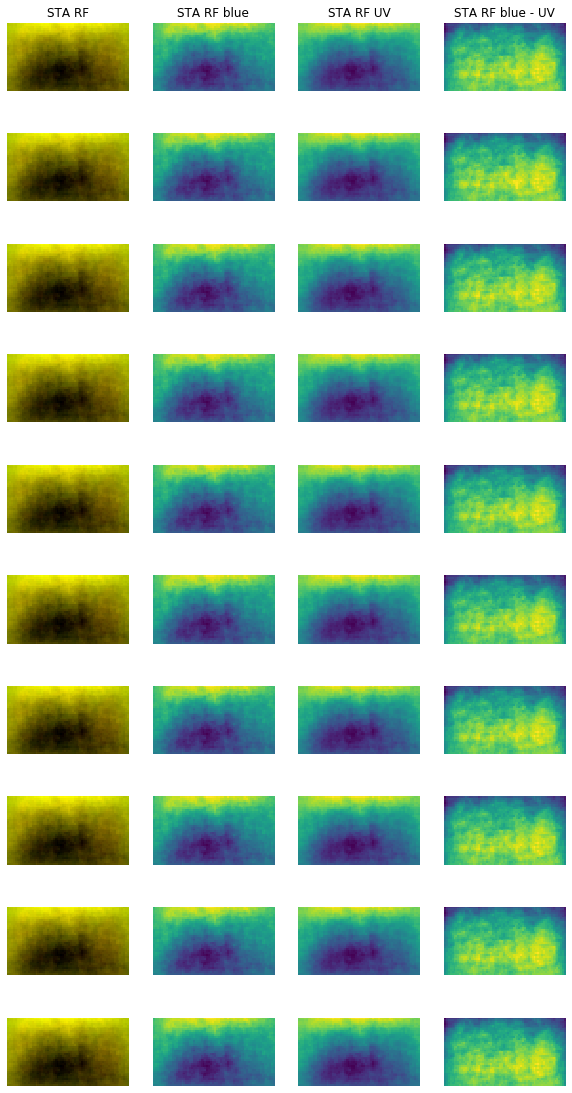

In [6]:
fig = fake_signal_generation.FakeStaticSpikeTriggeredAverageRF.plot_sta(key=keys[0])

(array([1.00000e+00, 0.00000e+00, 2.00000e+00, 3.00000e+00, 2.00000e+00,
        1.10000e+01, 1.00000e+01, 2.10000e+01, 2.00000e+01, 2.80000e+01,
        4.80000e+01, 5.00000e+01, 8.90000e+01, 1.14000e+02, 1.87000e+02,
        2.71000e+02, 4.10000e+02, 4.81000e+02, 7.06000e+02, 9.30000e+02,
        1.23300e+03, 1.63900e+03, 2.07500e+03, 2.74500e+03, 3.48600e+03,
        4.33000e+03, 5.30800e+03, 6.59900e+03, 8.19100e+03, 1.03480e+04,
        1.23170e+04, 1.50170e+04, 1.81630e+04, 2.15300e+04, 2.56430e+04,
        3.01560e+04, 3.51500e+04, 4.06360e+04, 4.70130e+04, 5.34650e+04,
        6.08030e+04, 6.87790e+04, 7.85090e+04, 8.82160e+04, 9.83440e+04,
        1.09450e+05, 1.20404e+05, 1.31852e+05, 1.42223e+05, 1.51214e+05,
        1.58930e+05, 1.61955e+05, 1.59808e+05, 1.52161e+05, 1.40027e+05,
        1.27030e+05, 1.15716e+05, 1.03943e+05, 9.33320e+04, 8.35340e+04,
        7.35030e+04, 6.53960e+04, 5.69330e+04, 5.00620e+04, 4.33090e+04,
        3.73270e+04, 3.23840e+04, 2.78280e+04, 2.37

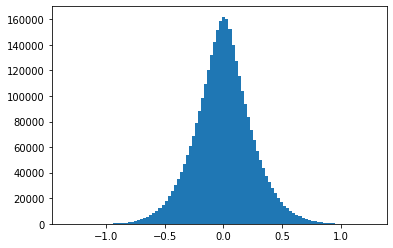

In [7]:
plt.hist(np.diff(sta_rf,axis=0).flatten(), bins=100)

In [10]:
fake_signal_generation.NoisyGaussianKernels()

kernel_hash MD5 in base64,noise_type noise type name,noise_params dictionary containing noise params,original_file_name katrin's file name,kernels noisy gaussian rfs
03dd7c83c9dd4f4c8b0402f72326be95,GaussianNoise,"{""mean"": 0.0, ""var"": 0.0001}",Gaussian_RFs_random_location.h5,=BLOB=
cdaebc77cfbaa39df54a646951d482ab,GaussianNoise,"{""mean"": 0.0, ""var"": 0.0001}",Gaussian_RFs.h5,=BLOB=


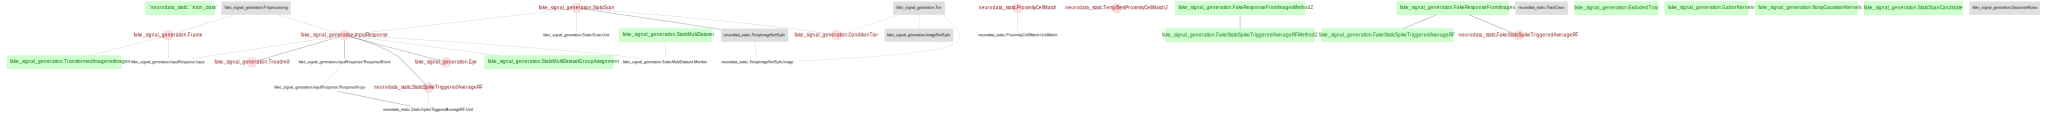

In [12]:
dj.ERD(schema)

In [14]:
# It is random in location, but deviation is not as wide as the "random location" case
kernels = (fake_signal_generation.NoisyGaussianKernels & "original_file_name='Gaussian_RFs.h5'").fetch1('kernels')

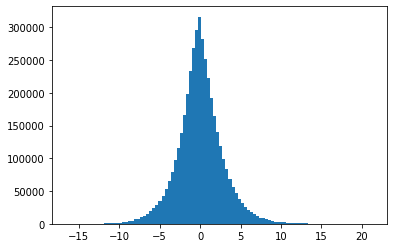

In [15]:
response = (fake_signal_generation.FakeResponseFromImages & keys[0]).fetch1('response')
response_diff = np.diff(response,axis=1)
response_diff_hist = plt.hist(response_diff.flatten(), bins=100)

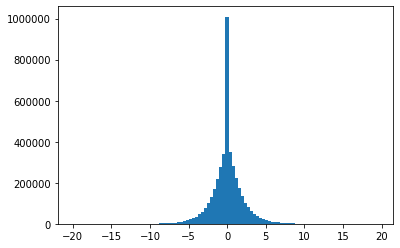

In [16]:
response_diff_img = np.diff(response,axis=0)
response_diff_hist = plt.hist(response_diff_img.flatten(), bins=100)

In [17]:
key = keys[0]
kernel_params = dict(kernel_type='NoisyGaussianKernels', kernel_hash = 'cdaebc77cfbaa39df54a646951d482ab')

In [101]:
stim_type = np.unique((stimulus.Condition & (stimulus.Trial & key)).fetch('stimulus_type'))

if len(stim_type) > 1:
    raise ValueError("There must be only 1 stimulus type! Currently there are stimuli of : {}".format(stim_type))
else:
    stim_type = stim_type[0].split('.')[1]
stim_table = getattr(stimulus, stim_type)

id_table = ((stimulus.Trial & key) * stim_table).proj('image_id','channel_1','channel_2','channel_3')
img_table = (stimulus.StaticImage.Image & 'image_class = "imagenet_v2_rgb"') & id_table

image_class, images = (id_table * img_table).fetch('image_class','image')
image_class = np.unique(image_class)

if len(image_class) > 1:
    raise ValueError("There must be only 1 image class! Currently there are : {} classes".format(image_class))
else:
    image_class = image_class[0]

# find which colors were used for imagenet images
colors = np.array((id_table & 'trial_idx = 0').fetch1('channel_1','channel_2','channel_3'))

valid_colors =(colors[colors != None] - 1).astype('int')

# obtain the kernels
kernel_table = fake_signal_generation.NoisyGaussianKernels
kernels = kernel_table.fetch1('kernels')

# number of neurons = number of kernels
num_neurons = kernels.shape[0]


In [6]:
# generate fake values
# response_block = np.zeros(shape=(len(images),len(kernels)))

convolved_matrix = np.zeros((6000,700,144,256,2))

# for img_ind, img in enumerate(images):
#     print(img_ind)
#     #TODO color_ind logic can be improved. For now, hardcoded for kernel channel config
#     restricted_img = np.zeros(shape=kernels.shape[1:])

#     for channel_ind, color_ind in enumerate(valid_colors):
#         restricted_img[:,:,channel_ind] = img[:,:,color_ind]  

#     convolved = np.multiply(restricted_img, kernels)
    
#     convolved_matrix[img_ind] = convolved
#     # introduce nonlinearity
#     convolved[convolved<0] = 0 

#     signals = convolved.reshape(num_neurons,-1).mean(-1)

#     response_block[img_ind,:] = signals


In [18]:
keys_temp =(neurodata_static.StaticMultiDatasetGroupAssignment() & keys & 'description like "Inserted%%"').fetch('KEY')

In [19]:
keys_temp

[{'group_id': 80,
  'animal_id': 22086,
  'session': 2,
  'scan_idx': 3,
  'pipe_version': 1,
  'segmentation_method': 6,
  'spike_method': 5,
  'preproc_id': 0},
 {'group_id': 78,
  'animal_id': 22845,
  'session': 7,
  'scan_idx': 5,
  'pipe_version': 1,
  'segmentation_method': 6,
  'spike_method': 5,
  'preproc_id': 0},
 {'group_id': 79,
  'animal_id': 22845,
  'session': 10,
  'scan_idx': 5,
  'pipe_version': 1,
  'segmentation_method': 6,
  'spike_method': 5,
  'preproc_id': 0},
 {'group_id': 81,
  'animal_id': 22904,
  'session': 4,
  'scan_idx': 2,
  'pipe_version': 1,
  'segmentation_method': 6,
  'spike_method': 5,
  'preproc_id': 0}]

In [20]:
data =(fake_signal_generation.FakeStaticSpikeTriggeredAverageRF & key).fetch()
df = pd.DataFrame(data)

In [21]:
rel = neurodata_static.StaticMultiDatasetGroupAssignment & keys & 'description like "Inserted%%"'
rel *= fake_signal_generation.FakeStaticSpikeTriggeredAverageRF
rel = dj.U('group_id', 'sta_rf') & rel
sta_rf = pd.DataFrame(rel.fetch())

In [22]:
sta_rf.columns

Index(['group_id', 'sta_rf'], dtype='object')

In [179]:
sta_rf = (fake_signal_generation.FakeStaticSpikeTriggeredAverageRF() & key).fetch1('sta_rf')

In [229]:
blue = []
uv = []
for sta in sta_rf:
    blue.append(np.std(sta[:,:,0].flatten()))
    uv.append(np.std(sta[:,:,1].flatten()))

In [230]:
np.arange(3.5,4,0.1), np.arange(4.0, 4.5, 0.1)

(array([3.5, 3.6, 3.7, 3.8, 3.9]), array([4. , 4.1, 4.2, 4.3, 4.4]))

Text(0, 0.5, 'UV')

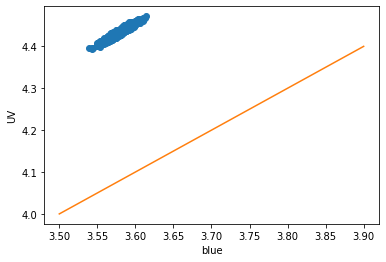

In [302]:
plt.plot(blue, uv, 'o')
plt.plot(np.arange(3.5,4,0.1), np.arange(4.0, 4.5, 0.1))
plt.xlabel('blue')
plt.ylabel('UV')

# debugging (Idk what I debugged here honestly)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd 
import os, shutil
import h5py

from neuro_data.static_images.data_schemas import * # bad practice
from staticnet_experiments.models import Model
from neuro_data.static_images.data_schemas import StaticMultiDataset

Connecting donnie@10.28.0.34:3306


In [2]:
stimulus = dj.create_virtual_module('stimulus','pipeline_stimulus')


In [3]:
stim_type = np.unique((stimulus.Condition & (stimulus.Trial & key)).fetch('stimulus_type'))
if len(stim_type) > 1:
     raise ValueError("There must be only 1 stimulus type! Currently there are stimuli of : {}".format(stim_type))
else:
    stim_type = stim_type[0].split('.')[1]
stim_table = getattr(stimulus, stim_type)

NameError: name 'key' is not defined

In [ ]:
id_table = ((stimulus.Trial & key) * stim_table).proj('image_id','channel_1','channel_2','channel_3')
img_table = (stimulus.StaticImage.Image & 'image_class = "imagenet_v2_rgb"') & id_table

image_class, images = (id_table * img_table).fetch('image_class','image')
image_class = np.unique(image_class)

In [4]:
if len(image_class) > 1:
    raise ValueError("There must be only 1 image class! Currently there are : {} classes".format(image_class))
else:
    image_class = image_class[0]

# find which colors were used for imagenet images
colors = np.array((id_table & 'trial_idx = 0').fetch1('channel_1','channel_2','channel_3'))

valid_colors =(colors[colors != None] - 1).astype('int')


NameError: name 'image_class' is not defined

In [240]:
valid_colors

array([1, 2])

In [241]:
kernel_table

neuro_data.ColorMEI_pilot.fake_signal_generation.NoisyGaussianKernels

In [242]:
kernels = kernel_table.fetch1('kernels')

# number of neurons = number of kernels
num_neurons = kernels.shape[0]

# generate fake values
response_block = np.zeros(shape=(len(images),len(kernels)))

In [243]:
for img_ind, img in enumerate(images[:1]):
    print(img_ind)
    #TODO color_ind logic can be improved. For now, hardcoded for kernel channel config
    restricted_img = np.zeros(shape=kernels.shape[1:])

    for channel_ind, color_ind in enumerate(valid_colors):
        restricted_img[:,:,channel_ind] = img[:,:,color_ind]  

    convolved = np.multiply(restricted_img, kernels)

    # introduce nonlinearity
    convolved[convolved<0] = 0 

    signals = convolved.reshape(num_neurons,-1).mean(-1)

    response_block[img_ind,:] = signals

0


In [253]:
(restricted_img - img[:,:,1:]).min()

0.0

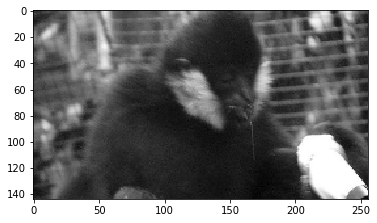

In [251]:
plt.imshow(img[:,:,2], cmap='gray')

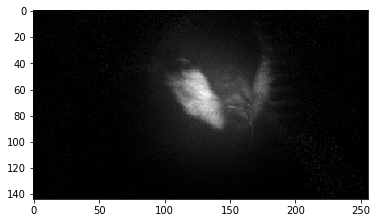

In [264]:
plt.imshow(convolved[100,:,:,1], cmap='gray')

In [13]:
response_block = (fake_signal_generation.FakeResponseFromImages & keys[0]).fetch1('response')
frames = (Frame * (stimulus.Trial & keys[0])).fetch('frame')
frames = np.stack(frames).astype(np.float32)

print('Iterating over units')
sta_rf = np.zeros(shape=(response_block.shape[-1],*frames.shape[1:]))

Iterating over units


In [18]:
sta_rf = (fake_signal_generation.FakeStaticSpikeTriggeredAverageRF & keys[0]).fetch1('sta_rf')

In [21]:
response_block.shape, frames.shape

((6000, 700), (6000, 36, 64, 2))

In [283]:
fake_signal_generation.FakeStaticSpikeTriggeredAverageRF & key

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,response_hash MD5 in base64,sta_rf STA using fake response
22086,2,3,6ba832eddb5227399bcf4369183b429a,=BLOB=


In [285]:
kernels = fake_signal_generation.NoisyGaussianKernels.fetch1('kernels')

In [287]:
blue_kernel = []
uv_kernel = []

for kernel in kernels:
    blue_kernel.append(np.std(kernel[:,:,0].flatten()))
    uv_kernel.append(np.std(kernel[:,:,1].flatten()))


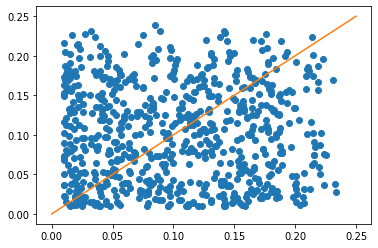

In [290]:
plt.plot(blue_kernel, uv_kernel, 'o')
plt.plot([0,0.25],[0,0.25])

In [33]:
blue_img = []
uv_img = []

for frame in frames:
    blue_img.append(np.std(frame[:,:,0].flatten()))
    uv_img.append(np.std(frame[:,:,1].flatten()))
    

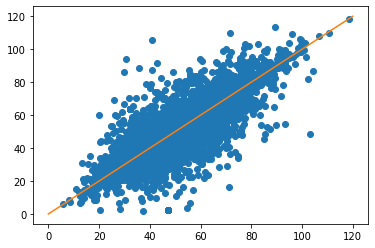

In [36]:
plt.plot(blue_img, uv_img, 'o')
plt.plot([0,120],[0,120])

In [30]:
response_train = response_block[:,0]
normalized_response_train = response_train/response_train.sum()

In [24]:
len(blue_img)

6000

In [45]:
sta_temp = np.average(frames, weights = normalized_response_train, axis=0)
sta_no_weights = np.average(frames, axis = 0)


In [51]:
blue_sum = []
uv_sum = []

for frame in frames:
    blue_sum.append(np.sum(frame[:,:,0].flatten()))
    uv_sum.append(np.sum(frame[:,:,1].flatten()))
    

In [61]:
import seaborn as sns

array([[253406., 236641.],
       [209717., 156042.],
       [206580., 190332.],
       ...,
       [343784., 331404.],
       [235547., 132421.],
       [266816., 254738.]], dtype=float32)

In [68]:
df = pd.DataFrame(np.array([blue_sum, uv_sum]).T, columns=['blue_sum','uv_sum'])

In [69]:
df.keys()

Index(['blue_sum', 'uv_sum'], dtype='object')

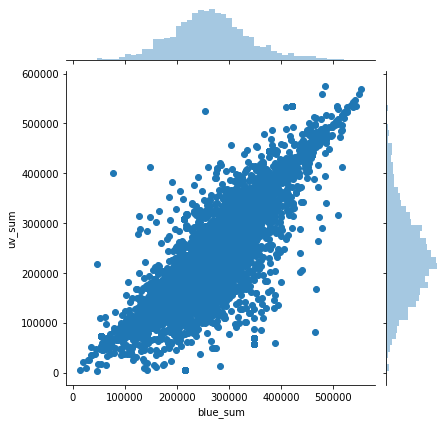

In [75]:
fig = sns.jointplot(x="blue_sum", y="uv_sum", data=df)

(array([  8.,  33.,  33., 102., 179., 362., 460., 728., 897., 947., 780.,
        547., 342., 217., 125.,  99.,  76.,  34.,  21.,  10.]),
 array([ 13327.  ,  40388.95,  67450.9 ,  94512.85, 121574.8 , 148636.75,
        175698.7 , 202760.66, 229822.6 , 256884.55, 283946.5 , 311008.44,
        338070.4 , 365132.34, 392194.3 , 419256.25, 446318.2 , 473380.16,
        500442.1 , 527504.06, 554566.  ], dtype=float32),
 <a list of 20 Patch objects>)

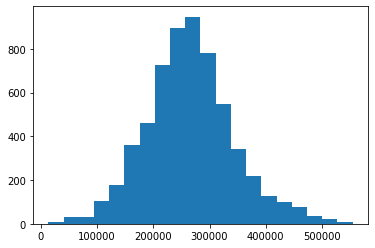

In [59]:
plt.hist(blue_sum, bins=20)

(array([ 32.,  72., 161., 290., 461., 593., 728., 856., 729., 648., 462.,
        312., 219., 126., 118.,  97.,  41.,  26.,  25.,   4.]),
 array([  3800. ,  32405.2,  61010.4,  89615.6, 118220.8, 146826. ,
        175431.2, 204036.4, 232641.6, 261246.8, 289852. , 318457.2,
        347062.4, 375667.6, 404272.8, 432878. , 461483.2, 490088.4,
        518693.6, 547298.8, 575904. ], dtype=float32),
 <a list of 20 Patch objects>)

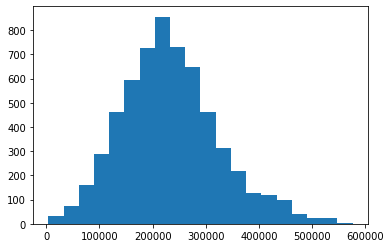

In [60]:
plt.hist(uv_sum, bins=20)

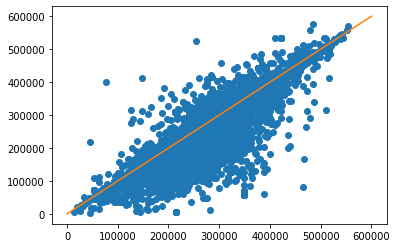

In [54]:
# plt.plot(blue_sum, uv_sum, 'o')
# plt.plot([0,600000],[0,600000])

In [49]:
print(sta_temp[:,:,0].std(),sta_temp[:,:,1].std())
print(sta_no_weights[:,:,0].std(),sta_no_weights[:,:,1].std())
print(sta_sum[:,:,0].std(),sta_sum[:,:,1].std())

3.5783306545549447 4.4290253103332144
3.633246 4.524141
21799.475 27144.846


In [50]:
frames.shape
frame_sum = frames.sum(axis=0)
print(frame_sum[:,:,0].std(),frame_sum[:,:,1].std())

21799.475 27144.846


In [304]:

blue_mother = []
uv_mother = []

for key in keys:
    sta_rf = (fake_signal_generation.FakeStaticSpikeTriggeredAverageRF() & key).fetch1('sta_rf')
    blue = []
    uv = []
    for sta in sta_rf:
        blue.append(np.std(sta[:,:,0].flatten()))
        uv.append(np.std(sta[:,:,1].flatten()))
        
    blue_mother.append(blue)
    uv_mother.append(uv)

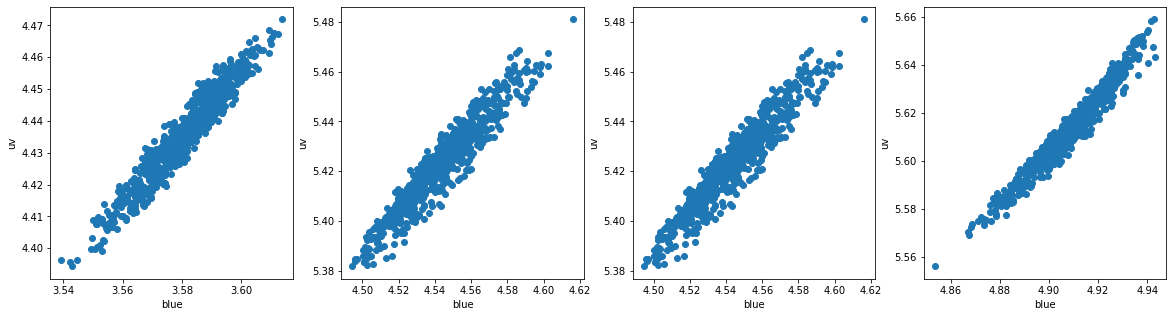

In [311]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

for i in range(4):
    ax[i].plot(blue_mother[i], uv_mother[i],'o')
    ax[i].set_xlabel('blue')
    ax[i].set_ylabel('uv')


In [312]:
from neuro_data.pipeline_management import spike_triggered_avg_rf

In [316]:
sta_rf_real = (spike_triggered_avg_rf.StaticSpikeTriggeredAverageRF.Unit & keys[0]).fetch('sta_rf')

In [321]:
sta_rf_real = np.stack(sta_rf_real)

In [323]:
real_blue = []
real_uv = []

for sta_real in sta_rf_real:
    real_blue.append(np.std(sta_real[:,:,0].flatten()))
    real_uv.append(np.std(sta_real[:,:,1].flatten()))

Text(0, 0.5, 'uv')

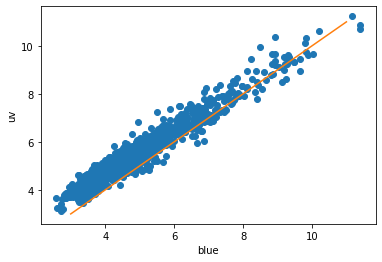

In [326]:
plt.plot(real_blue, real_uv, 'o')
plt.plot([3,11],[3,11])
plt.xlabel('blue')
plt.ylabel('uv')

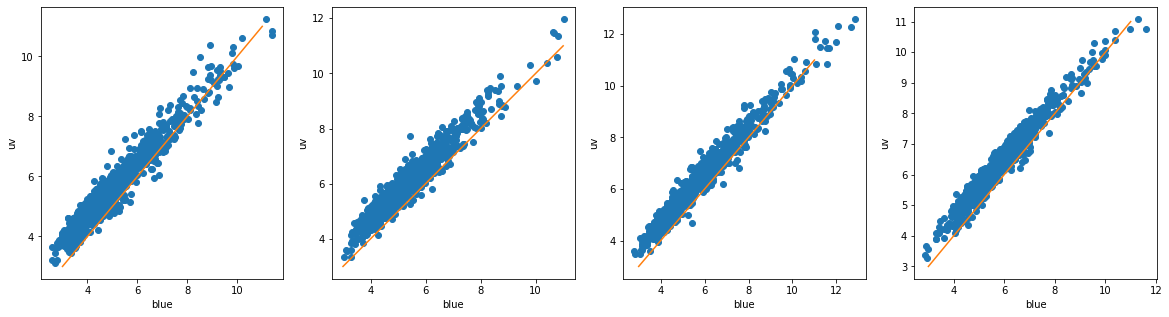

In [328]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

for ind, key in enumerate(keys):
    sta_rf_real = (spike_triggered_avg_rf.StaticSpikeTriggeredAverageRF.Unit & key).fetch('sta_rf')
    sta_rf_real = np.stack(sta_rf_real)
    
    real_blue = []
    real_uv = []

    for sta_real in sta_rf_real:
        real_blue.append(np.std(sta_real[:,:,0].flatten()))
        real_uv.append(np.std(sta_real[:,:,1].flatten()))
    
    ax[ind].plot(real_blue, real_uv, 'o')
    ax[ind].plot([3,11],[3,11])
    ax[ind].set_xlabel('blue')
    ax[ind].set_ylabel('uv')

In [77]:
frames.shape

(6000, 36, 64, 2)

In [95]:
with h5py.File('reduced_size_album.h5', "w") as f:
    f.create_dataset("album", data=frames)

In [96]:
with h5py.File('reduced_size_album.h5', 'r') as hf:
    data = hf['album'][:]

In [105]:
images = np.stack(images)

In [107]:
images_2channel = images[:,:,:,1:]

In [109]:
with h5py.File('original_size_album.h5', "w") as f:
    f.create_dataset("album", data=images_2channel)